Наша основная цель аналитического исследования ответить на вопрос: <b>почему не смотря на большие вложения в рекламу компания терпит убытки.</b>  
Для ответа на этот вопрос нам предоставлены данные за период в 6 месяцев, на основе которых мы будем проводить исследовательский анализ.  
Файлы содержат информацию о посещениях сайта, информацию о заказах и расходах на рекламу.
  
  Чтобы достичь желаемой цели необходимо выполнить следующие задачи:
  1. проанализируем полученные данные на корректность
  2. проведем разведочный анализ данных, чтобы сформировать целостную картину о кампаниях
  3. расчитаем основные маркетинговые метрики LTV, CAC, ROI и рассмотрим их динамику
  4. на основе полученной картины сформируем рекомендации по оптимизации расходов

### Загрузите данные и подготовьте их к анализу

In [2]:
#импорт библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import random

In [3]:
#загрузка файлов
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    ad_costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    print("Не удалось загрузить файлы")

<h4>Поиск пропусков</h4>

Рассмотрим пропуски

In [4]:
visits.isna().sum()

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

In [5]:
orders.isna().sum()

User Id     0
Event Dt    0
Revenue     0
dtype: int64

In [6]:
ad_costs.isna().sum()

dt         0
Channel    0
costs      0
dtype: int64

Пропусков не обнаружено. Рассмотрим полные дубли строк


<h4>Поиск полных дублей</h4>

In [7]:
display(visits.duplicated().sum(), orders.duplicated().sum(), ad_costs.duplicated().sum())

0

0

0

Полных дублей строк не обнаружено. Поищем аномальные значения.

<h4>Поиск аномалий</h4>

In [8]:
visits[['Session Start', 'Session End']].apply(['max', 'min'])

,Session Start,Session End
max,2019-10-31 23:59:23,2019-11-01 01:38:46
min,2019-05-01 00:00:41,2019-05-01 00:07:06


In [9]:
display(visits['Region'].unique(), visits['Device'].unique(), visits['Channel'].unique())

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [10]:
orders[['Revenue', 'Event Dt']].apply(['max', 'min'])

,Revenue,Event Dt
max,49.99,2019-10-31 23:56:56
min,4.99,2019-05-01 00:28:11


In [11]:
ad_costs[['Channel', 'costs']].apply(['max', 'min'])

,Channel,costs
max,lambdaMediaAds,630.0
min,AdNonSense,0.8


In [12]:
ad_costs

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


In [13]:
display(ad_costs['Channel'].unique())

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Первичное ознакомление со значениями фреймов данных не выявил серьезных аномалий в именах или значениях. Однако можно заметить, что названия в колонках указаны разным регистром с пробелами в них, что может приводить к ошибками в ходе работы. Приведем названия к общему виду.

In [14]:
visits.columns=['user_id','region','device','channel','session_start','session_end']

orders.columns=['user_id', 'event_dt','revenue']

ad_costs.columns=['dt','channel','costs']

Проверим, есть ли необходимость в преобразовании данных в датафреймах.

<h4>Преобразование данных</h4>

In [15]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Приведем столбцы session_start и session_end к формату типа datetime для дальнейшей работы с датой и временем.

In [16]:
#преобразование object в datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [17]:
#преобразование object в datetime
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [18]:
#преобразование object в datetime
ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])

<h4>Общий вывод</h4>
  
На первый взгляд нам достались довольно "чистые" данные: не обнаружено пропусков и аномально откланяющихся значений. Потребовалось только преобразовать даты для дальнейшей работы с ними.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Разместим функции подсчета метрик, данные нам ранее в теории

In [19]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [20]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [21]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [22]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Функции визуализации метрик

In [23]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [24]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [25]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [26]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

<b>Вывод:</b>  
  
Мы подготовили функции для дальнейшей работы.

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

<h4>Составление профилей пользователей</h4>

Воспользуемся функцией get_profiles() для этого. Слегка модифицируем её, убрав строки для обработки events, которых у нас нет.

In [27]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
#     for event in event_names:
#         if event in events['event_name'].unique():
#             profiles[event] = profiles['user_id'].isin(
#                 events.query('event_name == @event')['user_id'].unique()
#             )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    new_users['dt'] = pd.to_datetime(new_users['dt'])
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [28]:
profiles = get_profiles(visits, orders, ad_costs)

Рассмотрим минимальную и максимальную дату привлечения

In [29]:
print('Минимальная дата привлечения', profiles.sort_values('first_ts').first_ts.iloc[0])
print('Максимальная дата привлечения', profiles.sort_values('first_ts').first_ts.iloc[-1])

Минимальная дата привлечения 2019-05-01 00:00:41
Максимальная дата привлечения 2019-10-27 23:59:04


<b>Вывод:</b>  
  
Мы свели информацию о пользователях в единую таблицу. Самая рання дата привлечения - 1 мая 2019 года, последняя дата привлечения - 27 октября 2019

<h4>Анализ платежеспособности стран</h4>

Воспользуемся таблицей profiles для выяснения: из каких стран приходят пользователи, в каком количестве и кто наиболее платежеспособен.

In [30]:
#подсчет пользователей сделавших/не сделавших покупку
country_users = profiles.groupby(['region', 'payer']) \
                           .agg({'user_id' : 'count'}) \
                           .rename(columns={'user_id': 'count'}) \
                           .reset_index()
country_users

,region,payer,count
0,France,False,16787
1,France,True,663
2,Germany,False,14365
3,Germany,True,616
4,UK,False,16875
5,UK,True,700
6,United States,False,93100
7,United States,True,6902


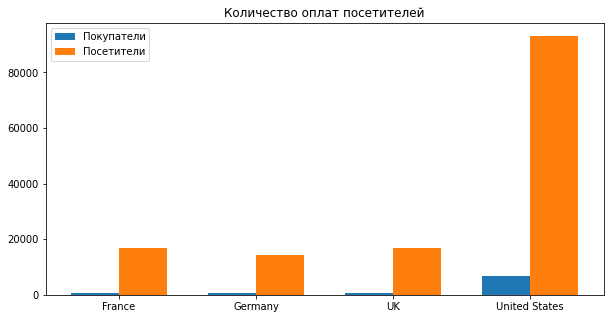

In [31]:
#на основе группировки строим столбчатую диаграмму

#создаем общий макет
fig, ax = plt.subplots(figsize=(10, 5)) 

# ширина столбца
width = 0.35
labels=country_users.query('payer == True')['region']

#указываем значения осей
x = np.arange(len(labels))
y1 = country_users.query('payer == True')['count']
y2 = country_users.query('payer == False')['count']

#строим графики
rects1 = ax.bar(x - width/2, y1, width , label='Покупатели')
rects2 = ax.bar(x + width/2, y2, width, label='Посетители')

#подписываем оси и легенды
ax.legend()
ax.set_title('Количество оплат посетителей')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.show()

Как мы можем увидеть, самая большая часть привлеченных пользователей из Соединенных штатов, соответственно и количество покупателей будет больше из этой страны.
  
Рассмотрим долю покупателей каждой страны.

In [32]:
#подсчет доли оплат от общего количества пользователей

country_payments = profiles.groupby('region') \
                           .agg({'user_id' : 'count', 'payer' : 'sum'}) \
                           .rename(columns={'user_id': 'user_count'}) \
                           .reset_index()

country_payments['share'] = ((country_payments['payer'] / country_payments['user_count']) * 100).apply('{:.2f}'.format)

country_payments

,region,user_count,payer,share
0,France,17450,663,3.80
1,Germany,14981,616,4.11
2,UK,17575,700,3.98
3,United States,100002,6902,6.90


<b>Вывод:</b>  
  
Самое большое количество привлеченных посетителей приходится на Соединенные Штаты, они же обладают самой высокой долей оплате - 6.9%, в то время как остальные регионы имеют приблизительно схожее значение в 4%.

<h4>Анализ устройств клиентов</h4>

In [33]:
#подсчет устройств пользователей сделавших/не сделавших покупку
user_device = profiles.groupby(['device', 'payer']) \
                           .agg({'user_id' : 'count'}) \
                           .rename(columns={'user_id': 'count'}) \
                           .reset_index()

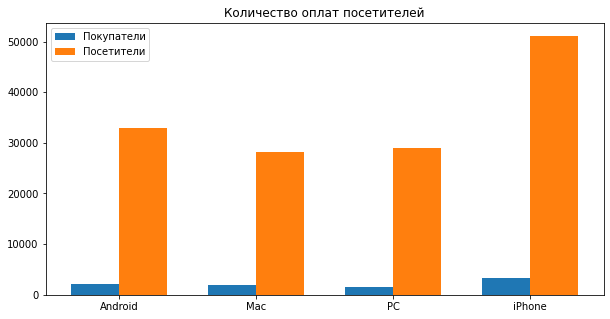

In [34]:
#на основе группировки строим столбчатую диаграмму

#создаем общий макет
fig, ax = plt.subplots(figsize=(10, 5)) 

# ширина столбца
width = 0.35
labels=user_device['device'].unique()

#указываем значения осей
x = np.arange(len(labels))
y1 = user_device.query('payer == True')['count']
y2 = user_device.query('payer == False')['count']

#строим графики
rects1 = ax.bar(x - width/2, y1, width , label='Покупатели')
rects2 = ax.bar(x + width/2, y2, width, label='Посетители')

#подписываем оси и легенды
ax.legend()
ax.set_title('Количество оплат посетителей')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.show()

In [35]:
#подсчет доли оплат от общего количества пользователей В разбивке по девайсами

device_payments = profiles.groupby('device') \
                           .agg({'user_id' : 'count', 'payer' : 'sum'}) \
                           .rename(columns={'user_id': 'device_users'}) \
                           .reset_index()

device_payments['share'] = ((device_payments['payer'] / device_payments['device_users']) * 100).apply('{:.2f}'.format)

device_payments

,device,device_users,payer,share
0,Android,35032,2050,5.85
1,Mac,30042,1912,6.36
2,PC,30455,1537,5.05
3,iPhone,54479,3382,6.21


In [36]:
#подсчет устройств по странам
user_region_device = profiles.groupby(['region', 'device']) \
                           .agg({'user_id' : 'count'}) \
                           .rename(columns={'user_id': 'count'}) \

user_region_device

count
region        device        
France        Android   5252
              Mac       1838
              PC        6940
              iPhone    3420
Germany       Android   4440
              Mac       1584
              PC        5945
              iPhone    3012
UK            Android   5141
              Mac       1778
              PC        7138
              iPhone    3518
United States Android  20199
              Mac      24842
              PC       10432
              iPhone   44529

<b>Вывод:</b>  
  
Лидером среди девайсов по количеству совершенных покупок является iPhone, а наибольшая доля покупок принадлежит устройствам фирмы Apple: Mac и iPhone.  
  Преимущественно владельцы данных девайсов - клиенты из США.

<h4>Анализ каналов привлечения клиентов</h4>

In [37]:
#подсчет источников пользователей сделавших/не сделавших покупку
channels = profiles.groupby(['channel', 'payer']) \
                           .agg({'user_id' : 'count'}) \
                           .rename(columns={'user_id': 'count'}) \
                           .reset_index()
channels

,channel,payer,count
0,AdNonSense,False,3440
1,AdNonSense,True,440
2,FaceBoom,False,25587
3,FaceBoom,True,3557
4,LeapBob,False,8291
5,LeapBob,True,262
6,MediaTornado,False,4208
7,MediaTornado,True,156
8,OppleCreativeMedia,False,8372
9,OppleCreativeMedia,True,233


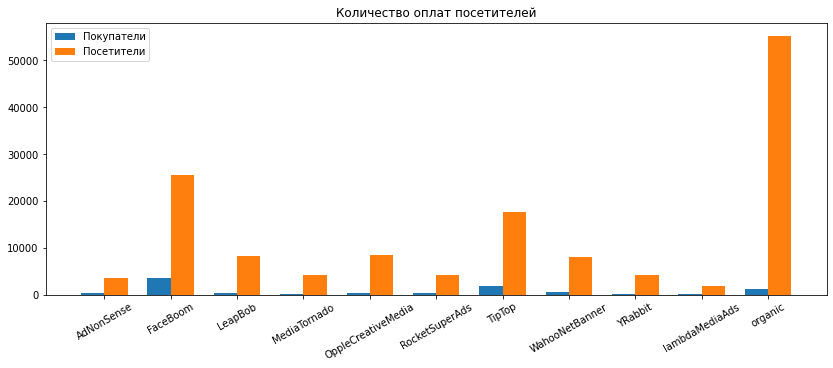

In [38]:
#на основе группировки строим столбчатую диаграмму

#создаем общий макет
fig, ax = plt.subplots(figsize=(14, 5)) 

# ширина столбца
width = 0.35
labels=channels['channel'].unique()

#указываем значения осей
x = np.arange(len(labels))
y1 = channels.query('payer == True')['count']
y2 = channels.query('payer == False')['count']

#строим графики
rects1 = ax.bar(x - width/2, y1, width , label='Покупатели')
rects2 = ax.bar(x + width/2, y2, width, label='Посетители')

#подписываем оси и легенды
ax.legend()
ax.set_title('Количество оплат посетителей')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)

plt.show()

In [39]:
#подсчет доли оплат от общего количества пользователей В разбивке по каналам привлечения

channel_payments = (
                    profiles.groupby('channel')
                    .agg({'user_id' : 'count', 'payer' : 'sum'})
                    .rename(columns={'user_id': 'channel_users'})
                    .reset_index()
                   )

channel_payments['share'] = (
                             ((channel_payments['payer'] / channel_payments['channel_users']) * 100)
                             .apply('{:.2f}'.format)
                             .astype('float64')
                            )

channel_payments = channel_payments.sort_values(by='share', ascending=False)

channel_payments

,channel,channel_users,payer,share
1,FaceBoom,29144,3557,12.20
0,AdNonSense,3880,440,11.34
9,lambdaMediaAds,2149,225,10.47
6,TipTop,19561,1878,9.60
5,RocketSuperAds,4448,352,7.91
7,WahooNetBanner,8553,453,5.30
8,YRabbit,4312,165,3.83
3,MediaTornado,4364,156,3.57
2,LeapBob,8553,262,3.06
4,OppleCreativeMedia,8605,233,2.71


<b>Вывод:</b>
  
В топ3 самых конвертируемых каналов привлечения вошли:
  - FaceBoom - 12.2%
  - AdNonSense - 11.34%
  - lambdaMediaAds - 10.47%
  
Большую часть клиентов по естественным причинам привлек органический канал, но конверсия в нём самая низкая.

<h4>Общий вывод</h4>  
Мы выяснили, что наши данные содержат информацию о странах, устройствах посетителей и каналах привлечения.  
Большую часть клиентов составляют посетители из США и владельцы устройств iPhone.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [40]:
print('Общая сумма расходов на маркетинг составила:', round(ad_costs['costs'].sum(), 2), 'у.е.')

Общая сумма расходов на маркетинг составила: 105497.3 у.е.


Структура затрат на рекламные источники выглядит следующим образом.

In [41]:
costs_by_channel = (
                    ad_costs.groupby('channel')
                            .agg({'costs' : 'sum'})
                            .sort_values('costs', ascending=False)
                            .reset_index()
                    )

costs_by_channel

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


Рассмотрим соотношение затрат

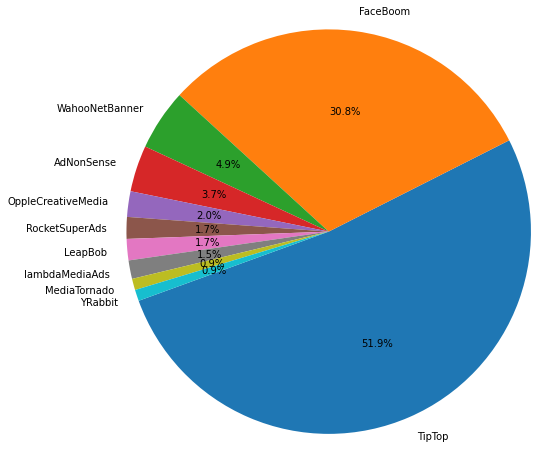

In [42]:
labels = costs_by_channel['channel']
sizes = costs_by_channel['costs']

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)
ax1.axis('equal')

plt.show()

Рекламные траты можно разделить на следующие источники:
 - TipTop - 54751.3 (51.9%)
 - FaceBoom - 32445.6 (30.8%)
 - Остальные - менее 5% трат на каждый из оставшихся каналов.

In [43]:
ad_costs['week'] = ad_costs['dt'].dt.isocalendar().week
ad_costs['month'] = ad_costs['dt'].dt.month

In [44]:
ad_costs

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5
...,...,...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0,43,10
1796,2019-10-24,lambdaMediaAds,6.4,43,10
1797,2019-10-25,lambdaMediaAds,8.8,43,10
1798,2019-10-26,lambdaMediaAds,8.8,43,10


In [45]:
week_ad_costs = ad_costs.groupby(['channel', 'week']).agg({'costs' : 'sum'}).unstack(level=0)

week_ad_costs

costs                                                   \
channel AdNonSense FaceBoom LeapBob MediaTornado OppleCreativeMedia   
week                                                                  
18          211.05    535.7   16.80        38.64              24.00   
19          273.00    750.2   31.71        61.68              34.50   
20          265.65    755.7   26.67        59.04              27.50   
21          266.70    722.7   26.67        50.16              34.25   
22          202.65   1208.9   65.52        36.96              81.75   
23          102.90   1081.3   66.99        27.60              79.50   
24           96.60   1042.8   52.29        29.76              71.50   
25          141.75   1280.4   68.46        32.16              79.75   
26          148.05   1647.8   99.75        40.56             107.00   
27          130.20   1536.7   87.36        43.44             102.50   
28          106.05   1124.2   62.58        28.80              81.00   
29           97.65    975.7   61.11        26.40              68.00   
30          118.65   1130.8   67.20        25.20              80.75   
31          141.75   1419.0   83.58        35.04              90.75   
32          116.55   1290.3   87.57        29.04             104.00   
33          117.60   1456.4   77.49        40.80              98.50   
34          142.80   1411.3   90.51        35.28             103.75   
35          133.35   1445.4   77.91        33.84              92.75   
36          100.80   1151.7   66.99        30.24              72.75   
37          100.80   1148.4   63.84        25.92              78.00   
38          139.65   1496.0   81.27        30.24             105.75   
39          192.15   1837.0  101.22        48.24             132.25   
40          155.40   1761.1  101.01        42.00             123.00   
41          136.50   1392.6   78.96        36.96              88.25   
42          118.65   1291.4   69.72        29.04              88.00   
43          154.35   1552.1   84.42        37.44             101.50   

                                                                      
channel RocketSuperAds  TipTop WahooNetBanner YRabbit lambdaMediaAds  
week                                                                  
18              99.450   347.0           49.2   52.20           81.6  
19             139.230   470.0           92.4   75.90          103.2  
20             138.060   454.0           90.0   69.30           90.4  
21             131.040   801.8           79.2   65.40          119.2  
22              97.695  1421.2          179.4   49.80           83.2  
23              76.050  1223.6          196.8   25.80           35.2  
24              63.180  1121.0          166.2   17.46           45.6  
25              80.730  1474.4          201.6   22.14           40.0  
26              78.260  2343.6          285.0   27.90           59.2  
27              75.075  2340.0          256.8   28.26           60.0  
28              55.965  1820.0          174.0   19.44           44.8  
29              41.860  1552.2          159.6   15.66           41.6  
30              54.600  1713.4          182.4   22.86           49.6  
31              61.880  2493.6          204.6   27.33           52.0  
32              69.615  2448.0          231.6   28.56           41.6  
33              62.010  2538.0          238.2   28.56           46.4  
34              40.300  2514.0          244.8   30.03           57.6  
35              51.350  2583.0          235.8   24.36           54.4  
36              40.625  2563.0          174.6   27.93           52.0  
37              40.950  2506.0          192.6   29.76           41.6  
38              56.225  3241.0          226.2   39.60           57.6  
39              63.700  3979.5          303.0   47.52           80.0  
40              66.300  3703.0          309.0   45.36           59.2  
41              51.675  3097.5          208.8   38.31           60.8  
42              46.475  2737.0      

In [46]:
#строим для каждого канала график динамики стоимости рекламных расходов понедельно
# ax = week_ad_costs.plot(kind='line', subplots=True, rot=0, figsize=(15, 15), layout=(5, 2))
# plt.tight_layout()

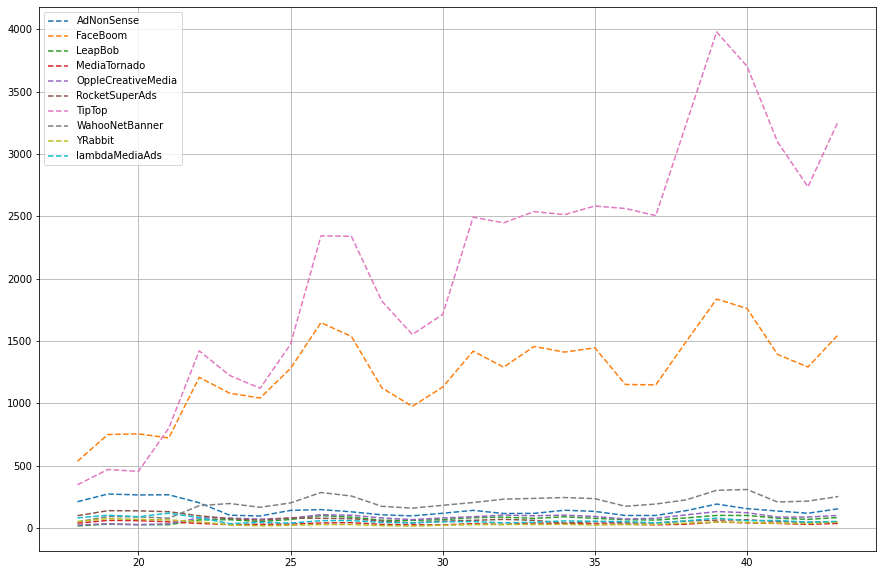

In [47]:
# задаём фигуру и прилагаем размеры
plt.figure(figsize=(15, 10))

#указываем параметр оси X
x = week_ad_costs.index

#передаем датафрейм оси Y
y = week_ad_costs['costs']

#устанавливаем график
plt.plot(x, y, '--')

#указываем подписи
plt.legend(y.columns)

#отображаем сетку
plt.grid()

#выводим график
plt.show()

In [48]:
month_ad_costs = (
                  ad_costs.groupby(['channel', 'month'])
                  .agg({'costs' : 'sum'})
                  .unstack(level=0)
                 )

month_ad_costs

costs                                                   \
channel AdNonSense FaceBoom LeapBob MediaTornado OppleCreativeMedia   
month                                                                 
5          1169.70   3524.4  140.28       238.56             169.75   
6           538.65   5501.1  314.58       138.00             370.00   
7           504.00   5294.3  313.53       138.48             366.50   
8           579.60   6274.4  369.81       154.56             439.25   
9           581.70   6114.9  343.98       144.72             427.75   
10          537.60   5736.5  315.42       140.16             378.00   

                                                                       
channel RocketSuperAds   TipTop WahooNetBanner YRabbit lambdaMediaAds  
month                                                                  
5              577.980   2981.0          418.8  299.70          458.4  
6              325.715   6675.6          921.0  106.20          199.2  
7              252.070   8410.2          851.4   97.38          219.2  
8              253.110  11202.0         1040.4  124.74          220.0  
9              218.400  13232.5          977.4  152.79          247.2  
10             205.725  12250.0          942.0  163.41          213.6

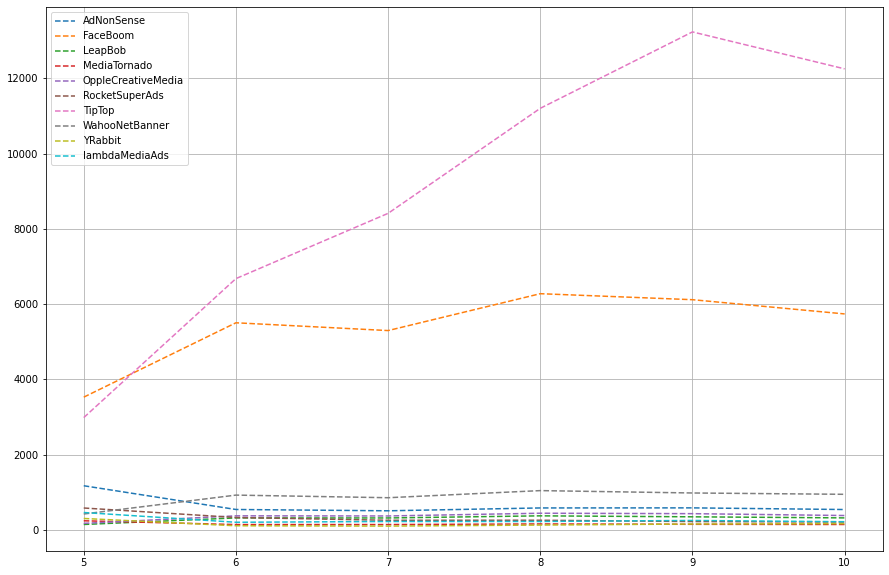

In [51]:
plt.figure(figsize=(15,10))

x = month_ad_costs.index

y = month_ad_costs['costs']

plt.plot(x, y, '--')
plt.grid()
plt.legend(y)

plt.show()

На графике видно, что для большинства каналов стоимость привлечения оставалась примерно на одном уровне.  

Однако 2 канала показали значительный рост стоимости рекламных расходов:
1. TipTop
2. FaceBoom

Рассчитаем CAC на основе данных таблицы profiles. В таблице уже есть данные по затратам на привлечение каждого клиента. Рассчитаем среднюю величину для каждого канала.

In [52]:
cac_mean = (
            profiles.groupby('channel')
            .agg({'acquisition_cost':'mean'})
            .rename(columns={'acquisition_cost' : 'mean_cac'})
            .sort_values('mean_cac', ascending=False)
            )

cac_mean['mean_cac'] = cac_mean['mean_cac'].apply('{:.2f}'.format)
                           
cac_mean

,mean_cac
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Из полученной таблицы видно, что стоимость привлечения из платных каналов значительно дороже остальных стоит в TipTop, а дешевле в LeapBob.  
  Расходы на канал Organic по естественным причинам равны нулю. 

<h4>Общий вывод:</h4>  
Метрика CAC менялась во времени для всех каналов, в особенности в первый месяц. Канал TipTop в среднем показал самую дорогую стоимость привлечения, а LeapBob самую выгодную.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

<h4>Общие показатели LTV, CR и Retention</h4>

Ранее в пункте 2 мы подготовили функции для расчета метрик. Применим их для наших данных.

In [53]:
#установим момент анализа 1 ноября 2019
#некорректный момент анализа
observation_date = datetime(2019, 11, 1).date() 

# установим горизонт анализа
#согласно задаче: "пользователи должны окупаться не позднее чем через две недели после привлечения"
horizon_days = 14

Прежде чем расчитывать данные, исключим данные канала Organic, чтобы нулевые значения не влияли на расчеты.

In [54]:
profiles = profiles.query('channel != "organic"')

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.

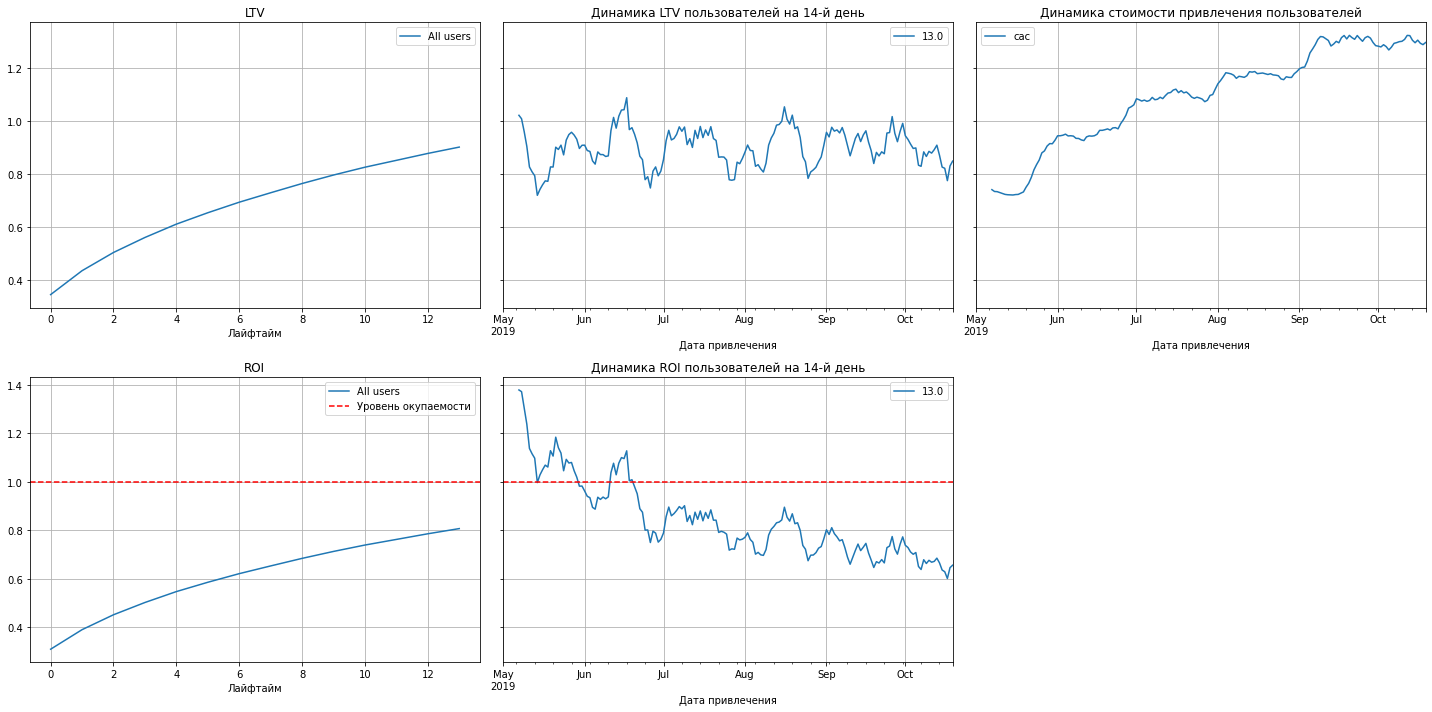

In [55]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- Графики показывают, что ROI не превысила 100%, что говорит о том, что вложенные средства не окупились.  
- Стоимость привлечения клиента с момента запуска рекламных кампаний значительно выросла.
- Динамика ROI имела негативный тренд на протяжении всей рекламной кампании  
- Динамика LTV сохранялась на примерно на одном уровне на протяжении всей кампании

Проверим конверсию пользователей и динамику её изменения, то же самое проделаем с удержанием пользователей.

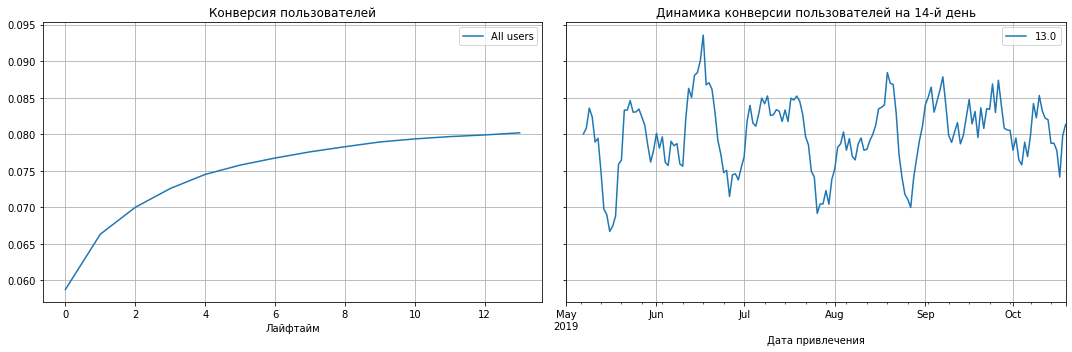

In [56]:
# смотрим конверсию

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Динамика конверсии была положительной и выросла с 6% до ~8%

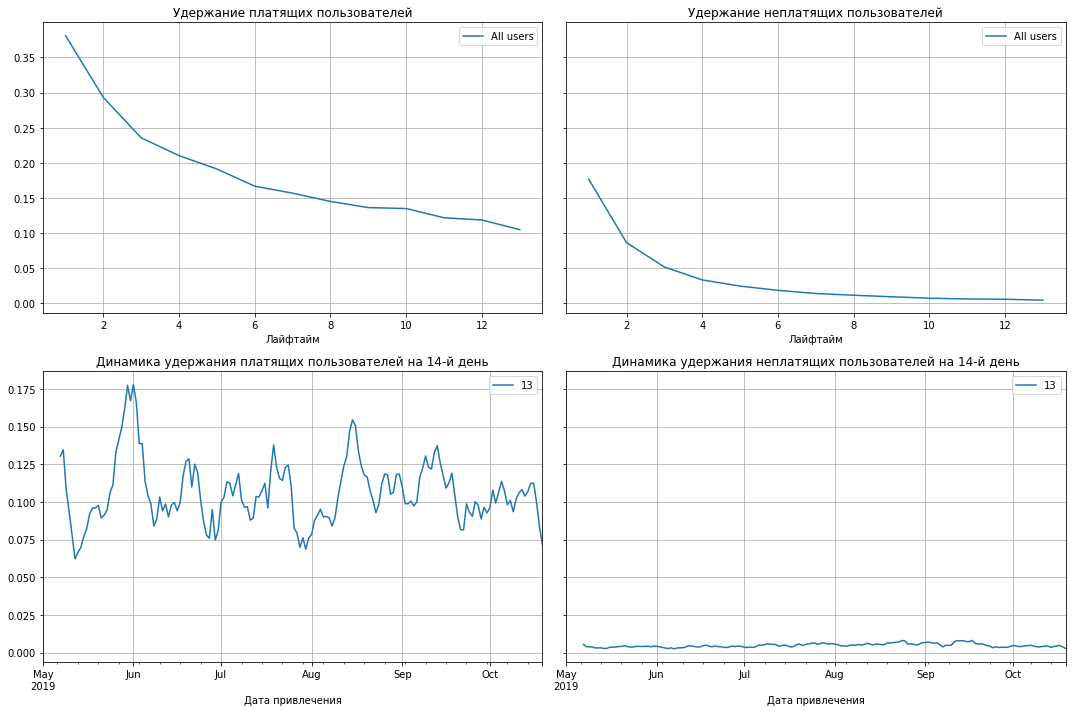

In [57]:
# смотрим удержание

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Данные указывают на естественное поведение удержания: постепенное снижение
- Динамика удержания не показывает аномальных отклонений

Графики представляют собой общие показатели рекламных кампаний. Проведем разбивку данных.

<h4>Retention в разбивке</h4>

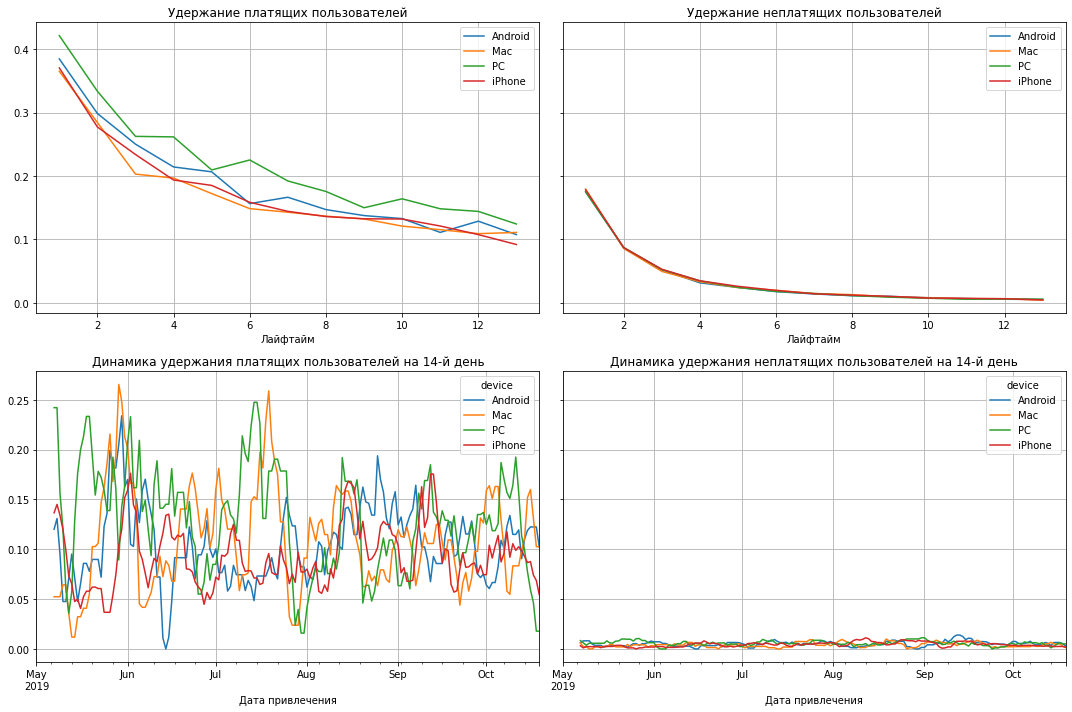

In [58]:
# смотрим удержание в разбивке по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Значительной разницы удержания в устройствах не обнаружено.

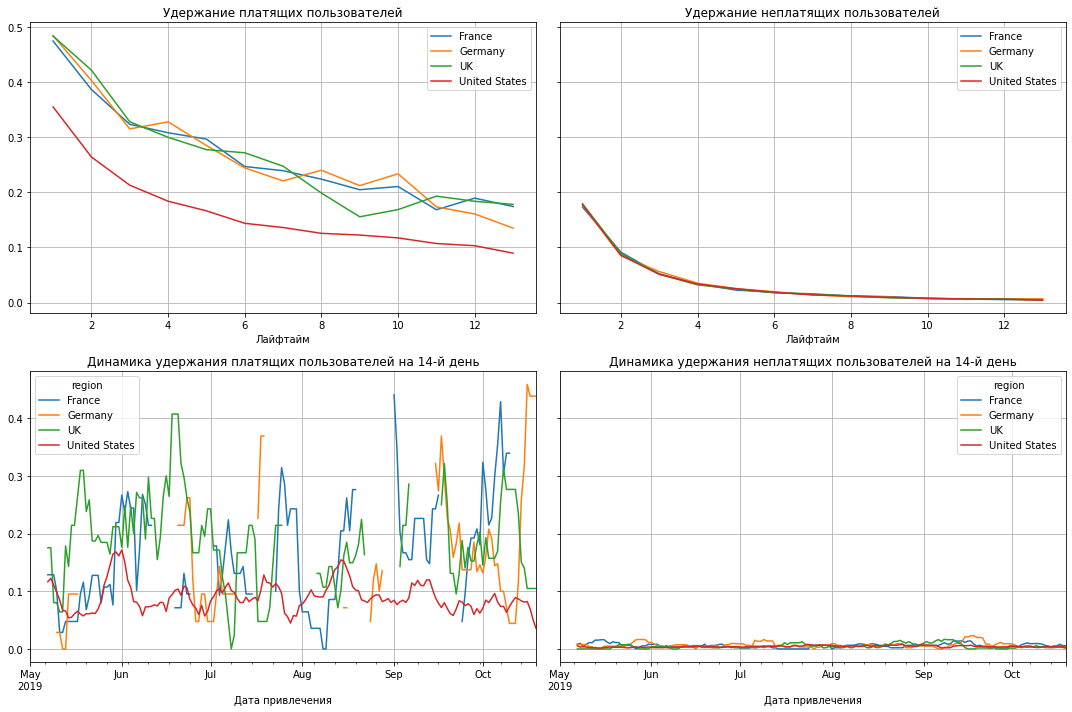

In [59]:
# смотрим удержание в разбивке по регионам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Среди стран уровень удержания клиентов хуже у региона США.

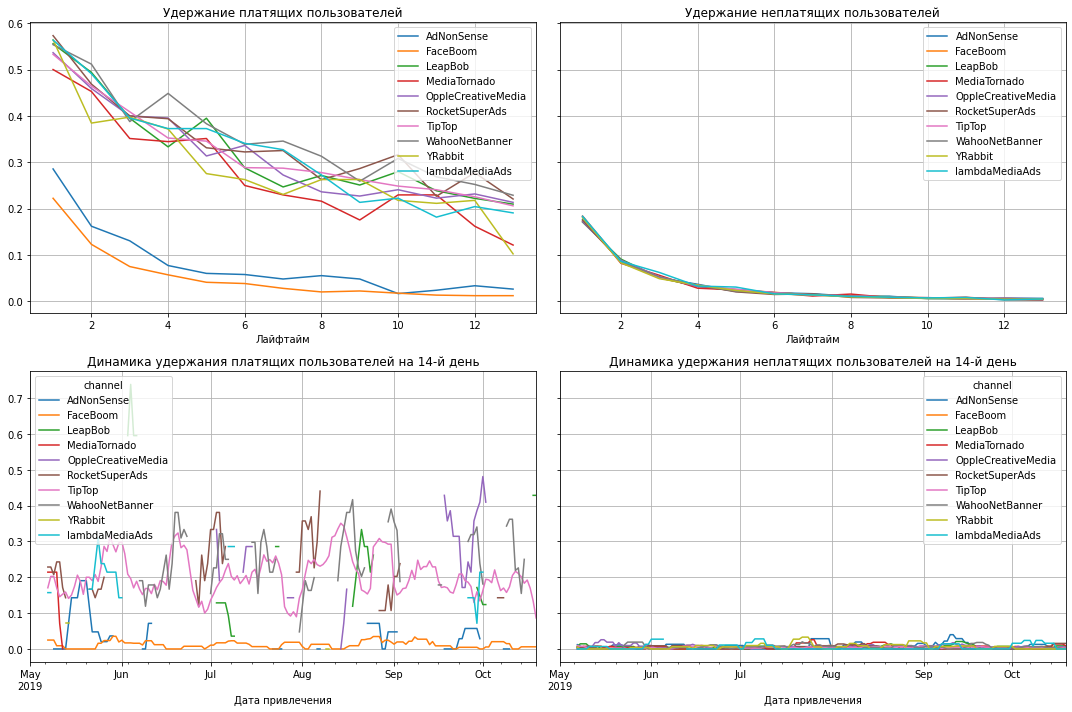

In [60]:
# смотрим удержание в разбивке по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание большинства каналов примерно на одном уровне, но AdNonSense и FaceBoom показывают значения существенно хуже.

<h4>CR в разбивке</h4>

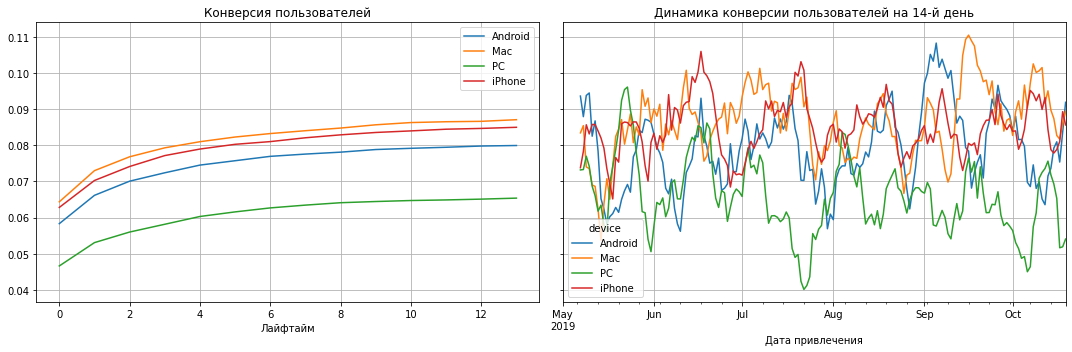

In [61]:
# смотрим конверсию в разбивке по девайсам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия с PC устройств существенно отстается по показателю конверсии от остальных. Отставание примерно на 2-2.5 п.п.

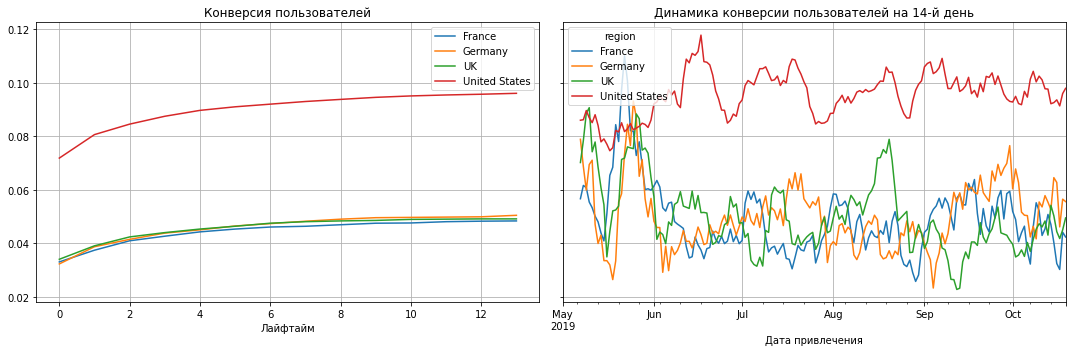

In [62]:
# смотрим конверсию в разбивке по регионам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Доля конверсия среди покупателей из США больше чем в 2 раза опережает CR покупателей из стран Европы. 

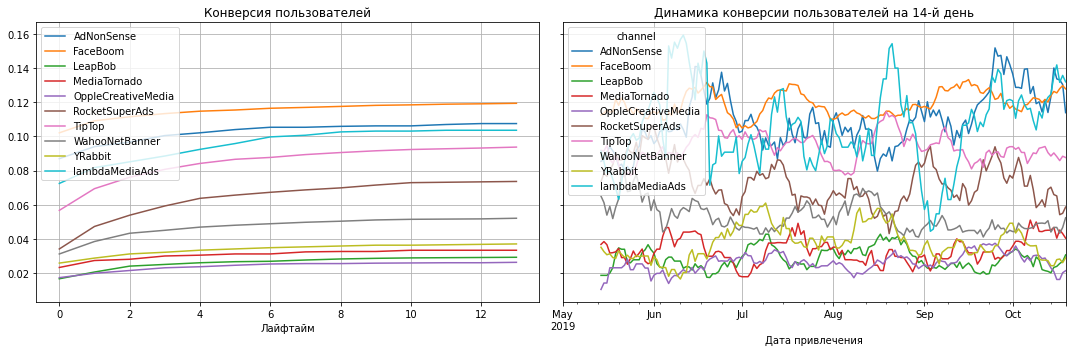

In [63]:
# смотрим конверсию в разбивке по девайсам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Не смотря на дороговизну каналов AdNonSense и FaceBoom, они показывают лучшие показатели конверсии. Однако, нельзя сказать, что их преимущество значительно.  
  LambdaMediaAds незначительно отстает, при этом показатели удержания этого канала лучше.

<h4>LTV и ROI в разбивке</h4>

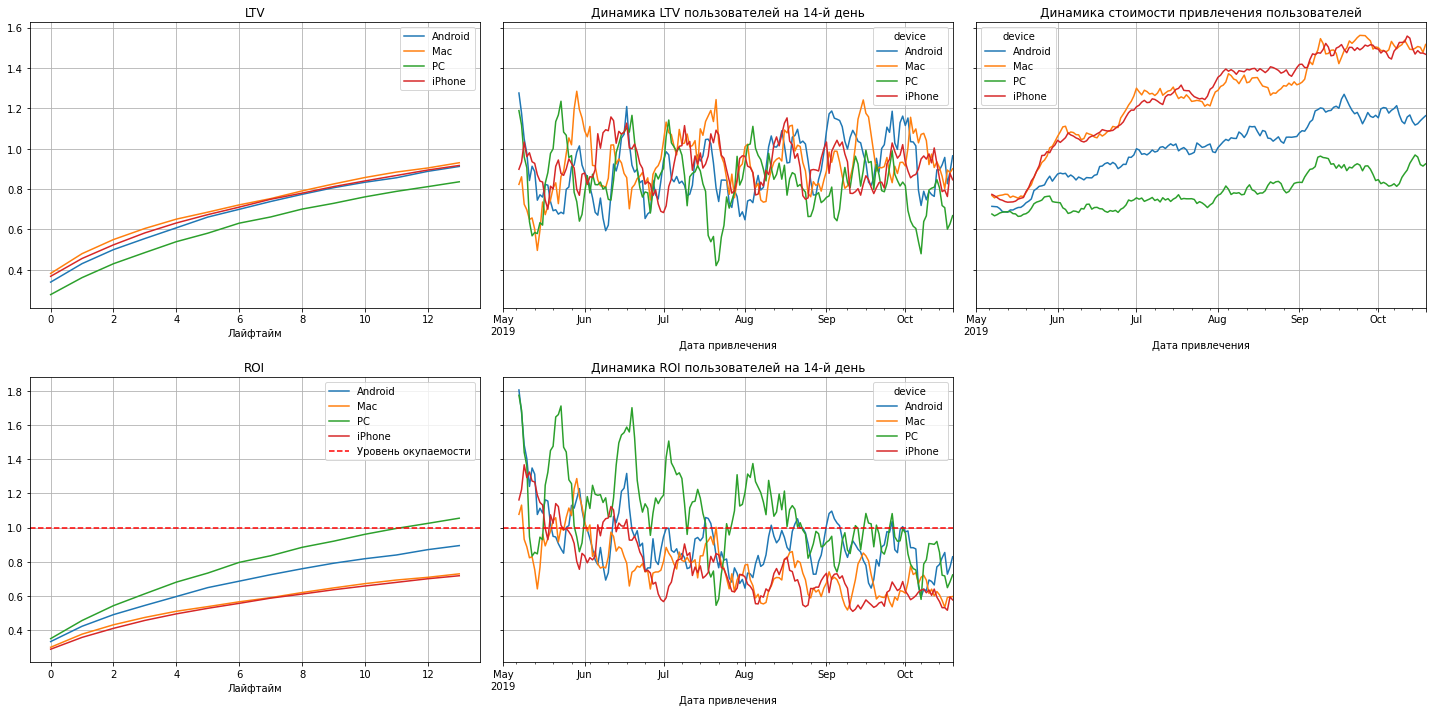

In [64]:
# считаем LTV и ROI в разбивке по девайсам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Согласно графикам на окупаемость успели выйти только кампании в которых посетители владеи устройствами PC. Объясняется это тем, что стоимость привлечения таких клиентов обходилась гораздо дешевле чем привлечени владельцев Mac и iPhone и Android.

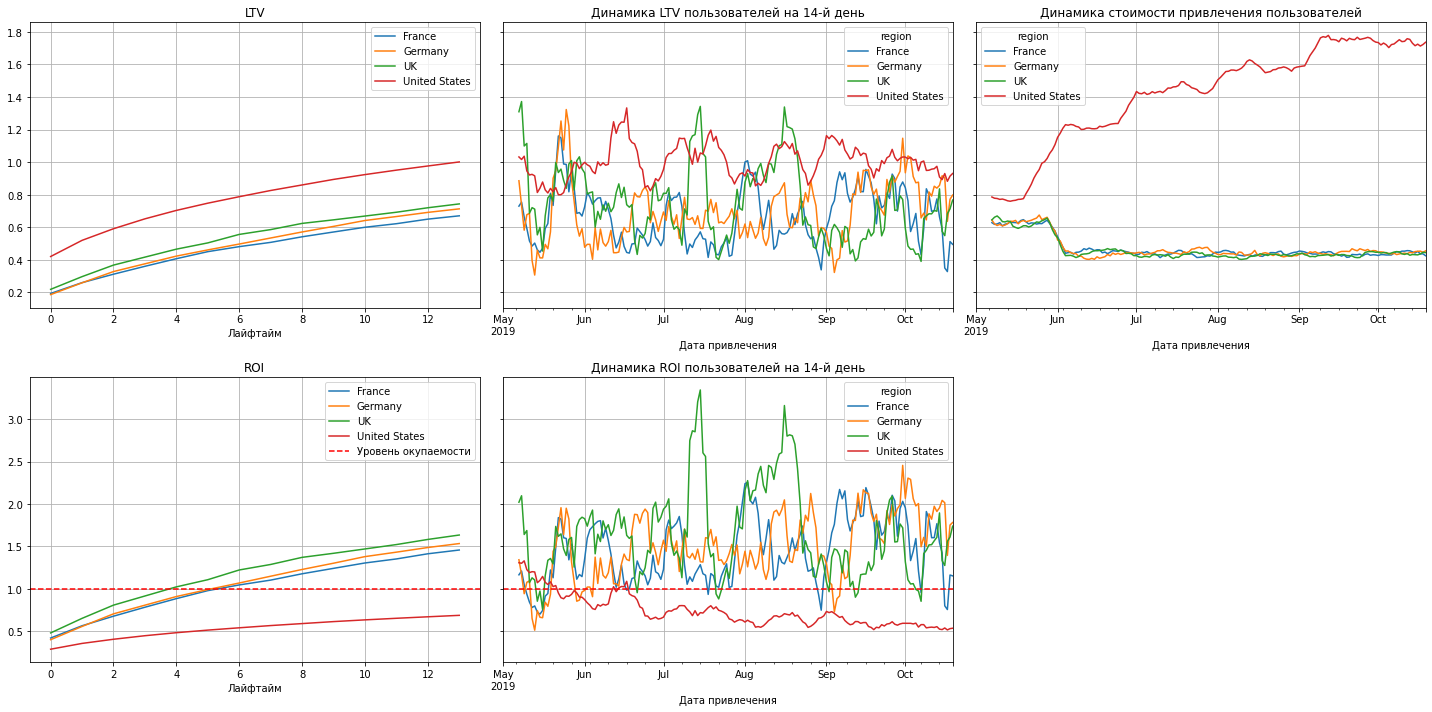

In [65]:
# считаем LTV и ROI в разбивке по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По данным графиков видно, что довольно быстро окупались клиенты из европейских стран и показывали положительную динамику ROI на протяжении всей рекламной кампании.  
Стоимость привлечения клиентов из США обходилась значительно дороже, что привело потерянным инвестициям.

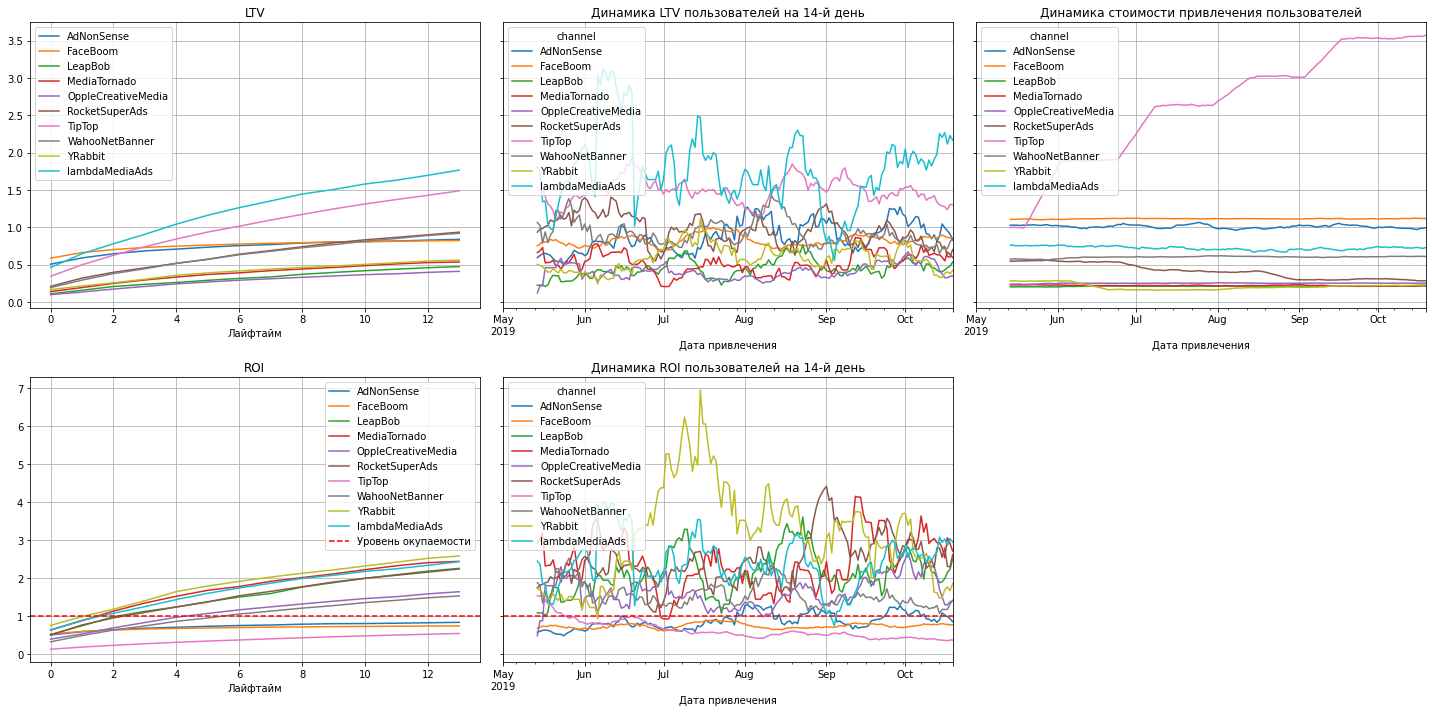

In [66]:
# считаем LTV и ROI в разбивке по каналам привлечения
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Большинство источников привлечения клиентов окупились. Можно выделить 3 самых плохих источника на основе ROI:
1. AdNonSense
2. TipTop
3. FaceBoom  
  
Стоимость CAC на данных каналах была самой высокой, а CAC канала TipTop и вовсе продемонстрировал суперудорожание.

<h4>Оценка региона US</h4>

В ходе оценки показателей кампании стало очевидно, что стратегия привлечения клиентов совершенно не сработала в регионе Соединенных Штатов. Попробуем детальней разобрать этот регион.  
Оставим для анализа только данные из US.

In [67]:
us_profiles = profiles.query('region == "United States"')

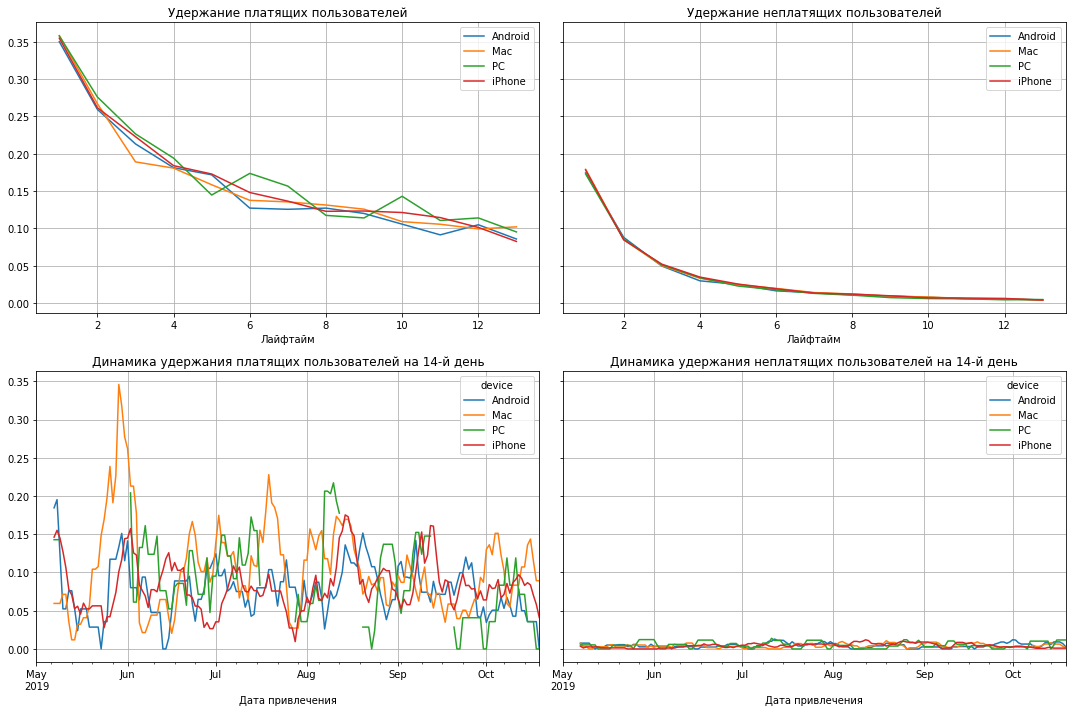

In [68]:
# смотрим удержание в разбивке по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    us_profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание среди устройств не содержит чего-либо приметного.

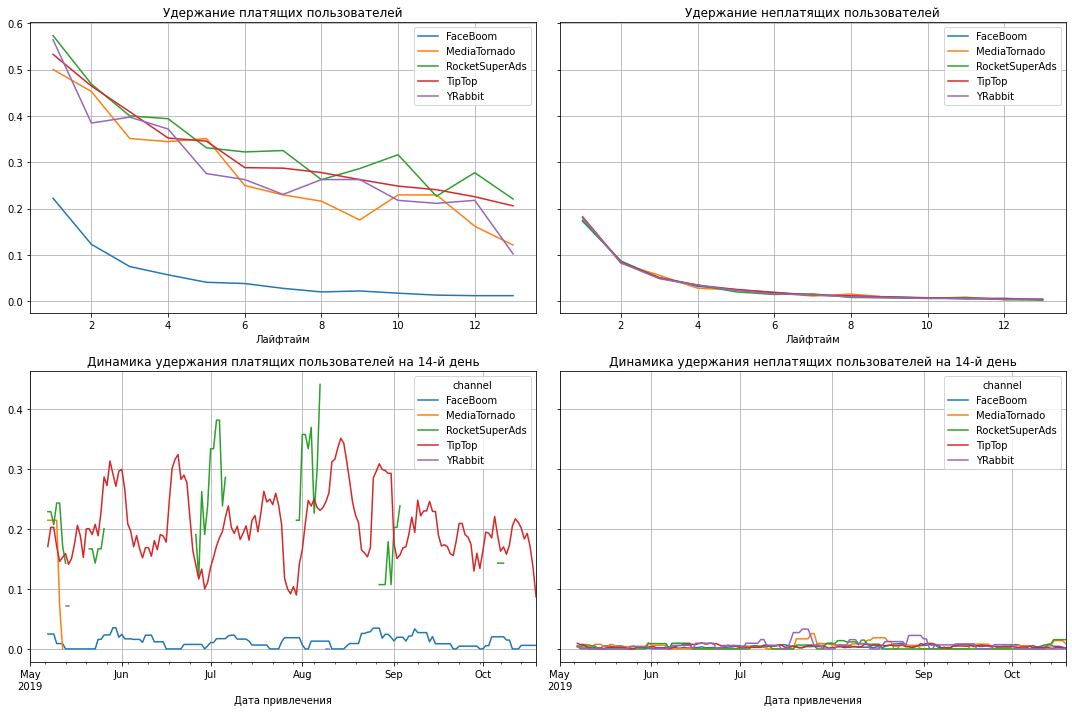

In [69]:
# смотрим удержание в разбивке по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    us_profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Показатели удержания FaceBoom значительно хуже остальных каналов.

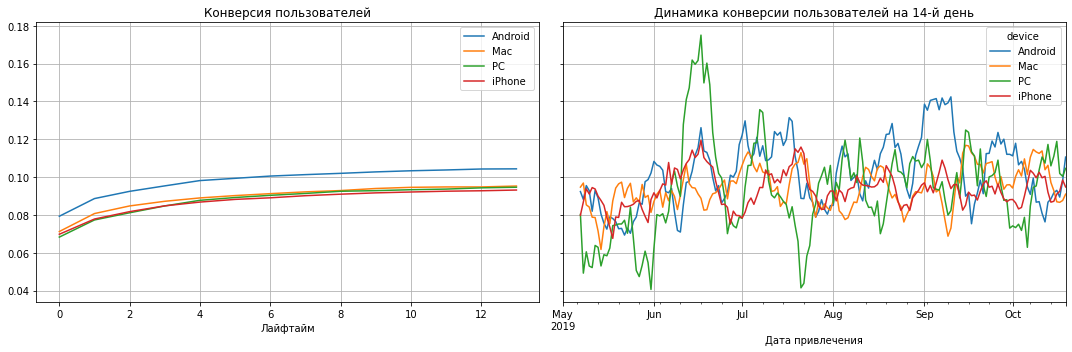

In [70]:
# смотрим конверсию в разбивке по девайсам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    us_profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

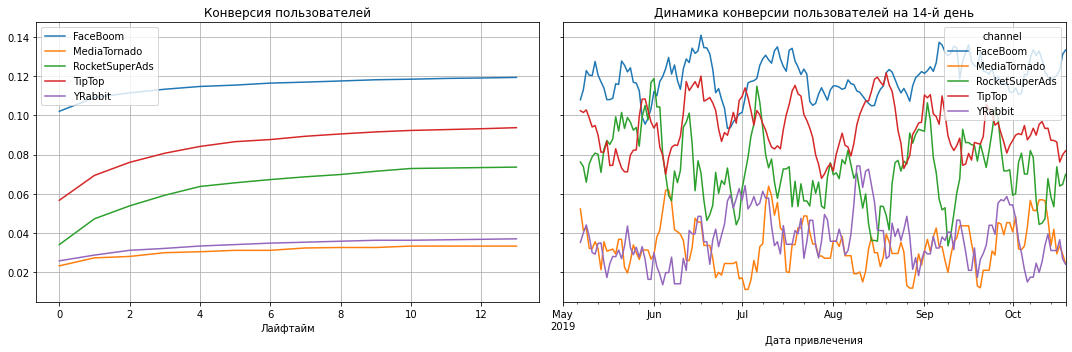

In [71]:
# смотрим конверсию в разбивке по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    us_profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

FaceBoom имеет лучшие показатели конверсии ~ 12%. TipTop - 9,5%. Наблюдается расслоение каналов по показателям конверсии.

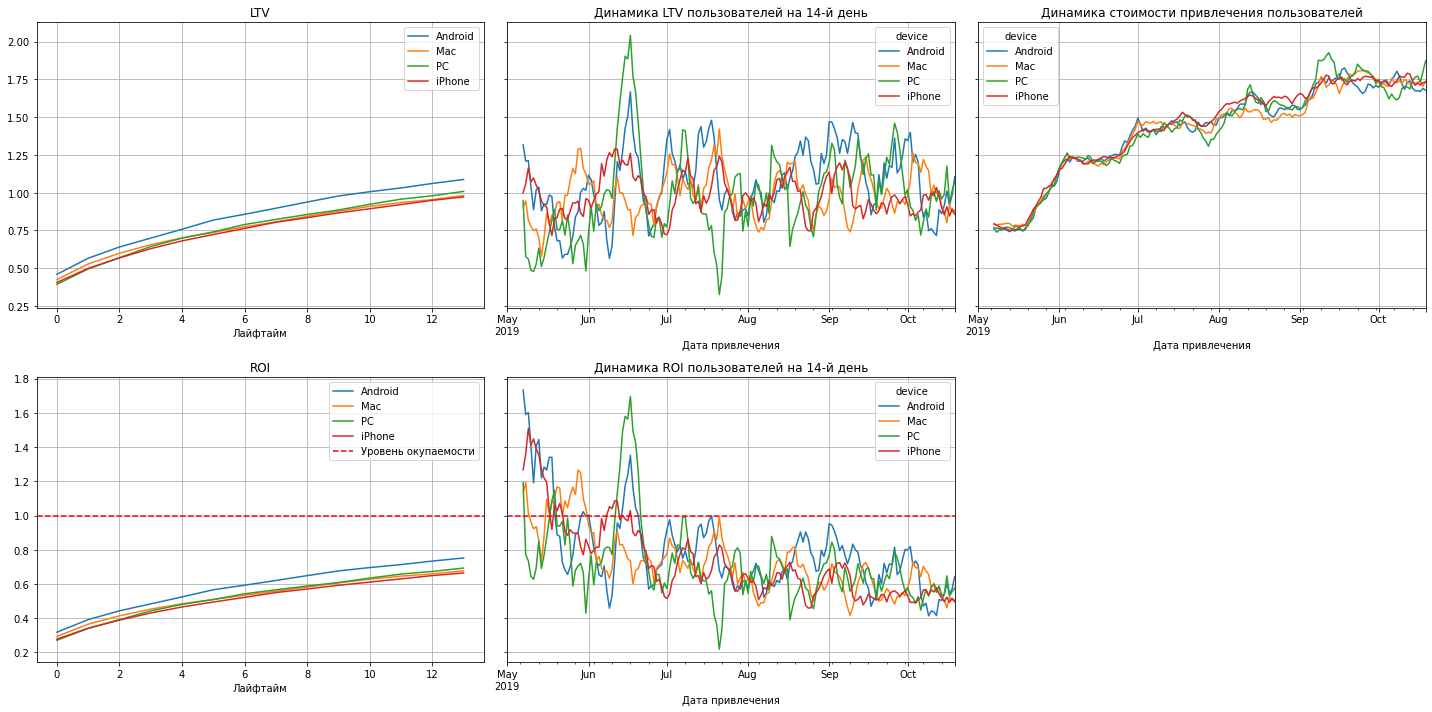

In [72]:
# считаем LTV и ROI в разбивке по девайсам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    us_profiles, orders, observation_date, horizon_days, dimensions=['device']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

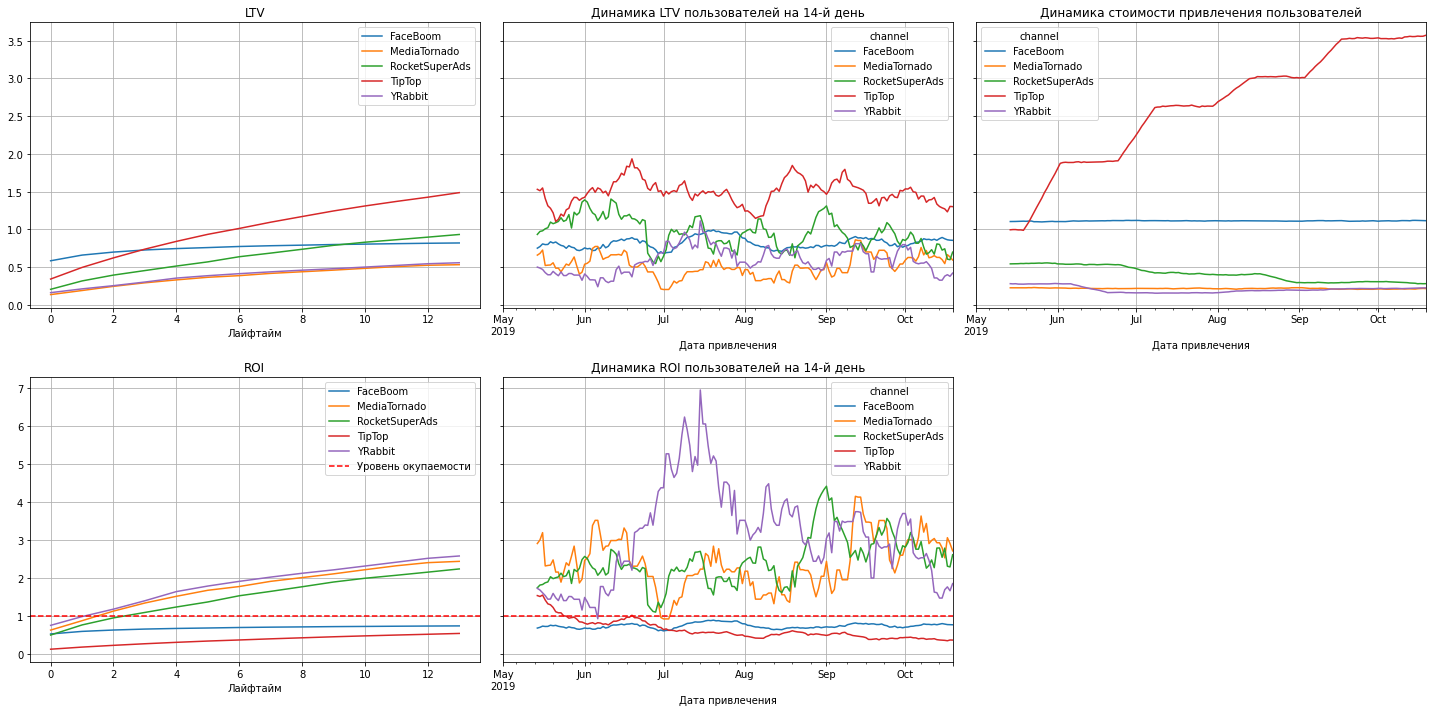

In [73]:
# считаем LTV и ROI в разбивке по каналам привлечения
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    us_profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

<h4>Общий вывод</h4>

Мы расчитали основные показатели и оценили окупаемость рекламной кампании. Теперь у нас достаточно данных на которых можно построить рекомендации.

### Вывод

К сожалению общий ROI кампаний не превысил 100%, что говорит о том, что инвестии в маркетинг не окупились. Проанализировав основные метрики (LTV, ROI, CAC) и  на основе их визуализации можно указать основную причину произошедшего: неэффективное расходование средств на привлечение клиентов.

Проблемные каналы:
1. На канал TipTop пришлось 50% от общего бюджета, его CAC существенно рос на протяжении всего полугода.
2. Канал FaceBoom на который ушло 30% общего рекламного бюджета не смотря на самый высокий рейтинг конверсии имеет очень низкие показатели LTV, из-за чего он так и не окупился.
3. AdNonSense - канал имеет низкий LTV, высокий CAC, что в сумме привело к низкому показателю ROI.

В целом основное влияние оказали каналы TipTop и FaceBoom на который пришлось 80% рекламного бюджета с неэффективным расходом.

  Среди устройств лучшими показателями LTV и CR обладали Mac и Iphone. Однако они не окупились из за высокой стоимости привлечения. Если принять меры и найти источники с более низким CAC для владельцев этих устройств - можно существенно увеличить доход.
  
  Отдельно стоит рассмотреть клиентов из США: не смотря на самый большой показатель LTV, эти клиенты так и не окупились. Причина кроется в самом низком показателе удержания, большое влияние на этот показатель повлиял канал FaceBoom, и очень высокой стоимостью привлечения из-за площадки TipTop.
  Рекомендуется перераспределить средства на другие каналы привлечения США (MediaTornado, RocketSuperAds, YRabbit). Лучшие показатели ROI в США среди устройств показал Android. Рекомендуется отдать больший бюджеты на рекламирование среди них при планировании кампании.